In [1]:
import sys
import os
import numpy as np
import numba
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'png'


from astropy.modeling import models, fitting
import Pk_library as PKL



sys.path.append("/u/ziyang/code/mycode/")
import illustris_python as il

import hmf
from hmf import MassFunction
from hmf.halos import mass_definitions as md
from hmf import cosmo

from astropy.modeling import models, fitting

from colossus.lss import bias
from colossus.lss import mass_function
from colossus.halo import mass_so, profile_nfw
from colossus.cosmology import cosmology
from colossus.halo import mass_defs
from colossus.halo import concentration


import MAS_library as MASL
import Pk_library as PKL

from dynesty import NestedSampler
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot



from scipy import interpolate

from halo_model import halo_model


# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
# Restore
def enablePrint():
    sys.stdout = sys.__stdout__
    

In [15]:
class bPe_calculate():
    def __init__(self, redshifts = [0], cosmo_model="planck13",
                 lgM_bins = np.linspace(8, 15, 100), 
                 lgx_bin = np.linspace(-3, 3, 100), x_max_cut=10, #pe_pro from model
                 dlgM=0, 
                 bh_model = "tinker10", hmf_model = "tinker08", Pe_model = "P13",
                 bh_simu=0, hmf_simu=0, Pe_simu=0, #Pe_simu.shape = len(x), len(M)
                 mdef = "500c",
                 mass_bias=0, alpha_p=0.12):
        
        cosmo = cosmology.setCosmology(cosmo_model);
        self.cosmo = cosmo
        
        
        dlgx = lgx_bin[1]-lgx_bin[0]
            
        if len(lgM_bins.shape) == 1:
            lgM_bins = lgM_bins.reshape(-1, 1) * np.ones((1, len(redshifts)))
        
        self.bPe = np.zeros(len(redshifts))
        self.bPe_d = np.zeros(len(redshifts))
        
        for i in range(len(redshifts)):
            lgM_bin = lgM_bins[:,i]
            dlgM = lgM_bin[1]-lgM_bin[0]
            
            
            redshift = redshifts[i]
                              
            

            #bh
            if bh_model == "simu":
                #from simu
                #len(M_bin) == len(bh_simu)
                if type(bh_simu) == int: print("bh simu type is wrong");return 1
                bh = bh_simu
            else:
                #from formula
                bh = bias.haloBias(10**lgM_bin, model = bh_model, z = redshift, mdef = mdef)

            #HMF  (cMpc/h)^-3
            if hmf_model == "simu":
                #from simu
                #len(M_bin) == len(hmf_simu)
                if type(hmf_simu) == int: print("hmf simu type is wrong");return 1
                dn = hmf_simu[:,i]
            else:
                #from formula
                dn=mass_function.massFunction(10**lgM_bin, z = redshift, mdef = mdef,
                                                      model = hmf_model, q_out = 'dndlnM')*np.log(10)*dlgM #len(M)
            
            #Pe_profile
            label = np.where(10**lgx_bin<x_max_cut)
            if Pe_model == "simu":
                #from simu
                #len(M_bin) == len(Pe_simu)
                if type(Pe_simu) == int: print("Pe simu type is wrong");return 1
                Pe_sum = Pe_simu[:,i]/Mpc2cm**3*(1+redshift)**3
            else:
                #from formula
                if mdef == "500c":
                    Pe_formula = self.pressure_profile_gNFW(x=(10**lgx_bin[label]).reshape(-1,1), M500=(10**lgM_bin).reshape(1,-1),
                                                        z=redshift, model=Pe_model, 
                                           mass_bias=mass_bias, alpha_p=alpha_p) #len(x), len(M)  #ev/cm^3
                    R500 = mass_so.M_to_R(M = 10**lgM_bin, z = redshift, mdef = mdef)/1000*(1+redshift) # cMpc/h
                elif mdef == "200m":
                    c=concentration.concentration(10**lgM_bin, '200m', z=redshift, model = 'bullock01')
                    M500, R500, c500 = mass_defs.changeMassDefinition(10**lgM_bin, z=redshift,c=c, mdef_in="200m", mdef_out="500c")
                    R500=R500/1000*(1+redshift)
                    Pe_formula = self.pressure_profile_gNFW(x=(10**lgx_bin[label]).reshape(-1,1),
                                                            M500=(M500).reshape(1,-1),
                                                        z=redshift, model=Pe_model, 
                                           mass_bias=mass_bias, alpha_p=alpha_p) #len(x), len(M)  #ev/cm^3
                
                #meV/cm^3 * (cMpc/h)^3
                Pe_sum = 4*np.pi*np.log(10)*R500**3*np.sum(Pe_formula * (10**(3*lgx_bin[label])*dlgx).reshape(-1,1), axis=0)
            
            
            self.bPe[i] = np.sum(bh*dn*Pe_sum)  #meV/cm^3
            

            #bPe diffused background
            
            lgM_bin_d = np.linspace(6, np.min(lgM_bin), 100)
            R500_d = mass_so.M_to_R(M = 10**lgM_bin_d, z = redshift, mdef = mdef)/1000*(1+redshift) # cMpc/h 

            dlgM_d = lgM_bin_d[1]-lgM_bin_d[0]
            bh_d = bh = bias.haloBias(10**lgM_bin_d, model = "tinker10", z = redshift, mdef = mdef)
            dndlgM_d = mass_function.massFunction(10**lgM_bin_d, z = redshift, mdef = mdef,
                                                      model = "tinker08", q_out = 'dndlnM')*np.log(10) #len(M)

            Pe_pro_d = self.pressure_profile_gNFW(x=(10**lgx_bin[label]).reshape(-1,1), M500=(10**lgM_bin_d).reshape(1,-1),
                                                        z=redshift, model="P13", 
                                           mass_bias=mass_bias, alpha_p=alpha_p) #len(x), len(M)  #ev/cm^3
            Pe_sum_d = 4*np.pi*np.log(10)*R500_d**3*np.sum(Pe_pro_d * (10**(3*lgx_bin[label])*dlgx).reshape(-1,1), axis=0)
            self.bPe_d[i] = np.sum(bh_d*dndlgM_d*Pe_sum_d*dlgM_d)  #meV/cm^3
            
    
    def pressure_profile_gNFW(self, x, M500, z, model, mass_bias, alpha_p):
        '''
        x = r/R500 np.array
        M500: M_sun/h 
        z: redshift 
        mass_bias: def=0
        model: "Planck13", "A10", "D23"

        return 
        Pe: meV/cm^3, same dimensions as x
        '''
        
        h_70 = self.cosmo.H0/70
        
        if model == "P13": # 62 SZ clusters
            P0=6.41
            gamma=0.31
            c500=1.81
            alpha=1.33
            beta=4.13
        if model == "A10": # arnaud, 2010; 33 X-ray clusters
            P0=8.403*h_70**-3/2
            gamma=0.3081
            c500=1.177
            alpha=1.051
            beta=5.4905
        if model == "D23": #denis, 2023; SZ stacking
            P0=5.9
            gamma=0.31
            c500=2
            alpha=1.8
            beta=4.9
            
        if model == "M23": #  Melin, 2023, SPT
            P0 = 10**0.23
            gamma = 0.71
            c500=0.61
            alpha = 1.05
            beta = 6.32

        #P_500
        E_z = (self.cosmo.Om0*(1+z)**3+1-self.cosmo.Om0)**(1./2) #float
        P_500 = (1-mass_bias)*1.65*10**-3*E_z**(8/3.)*(M500/(3*10**14*0.7))**(2/3+alpha_p)*h_70**2  #keV/cm^3, shape = M500.shape


        #P_x
        P_x = P0/((c500*x)**gamma * (1+(c500*x)**alpha)**((beta-gamma)/alpha)) #shape = x.shape
        

        return P_500 * P_x *10**6 #mev/cm3  

# fig 1 (bPe-S'8)

In [3]:
fid_params = {'flat': True, 'H0': 67.74, 'Om0': 0.3089, 'Ob0': 0.0486, 'sigma8': 0.8159, 'ns': 0.9667}  #Planck13, TNG

redshifts = np.array([0, 0.5, 1, 2, 3])
Om0 = np.linspace(0.24, 0.32, 10)
sigma8 = np.linspace(0.75, 0.88, 10)
h = np.linspace(0.66, 0.84, 10)

beta = 0.8

c = ["b", "r", "g", "m", "orange"]
N=100

Om0  = np.zeros(100)
sigma8 = np.zeros(100)
h = np.zeros(100)
bPe = np.zeros((100, 5))
for i in tqdm(range(N)):
    fid_params['Om0']= 0.28 + (np.random.rand()*2-1)*0.05
    fid_params['sigma8']= 0.81  + (np.random.rand()*2-1)*0.05
    fid_params['H0']= 66  + np.random.rand()*8
    cosmology.addCosmology('fid', **fid_params)

    bPe_HM = bPe_calculate(redshifts = redshifts, cosmo_model="fid")
    
    Om0[i] = fid_params['Om0']
    sigma8[i] = fid_params['sigma8']
    h[i] = fid_params['H0']/100
    bPe[i, :] = bPe_HM.bPe
    

100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.60it/s]


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 109.93it/s]


0.8141414141414143 0.6676767676767676


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 109.33it/s]


0.6020202020202021 0.5909090909090908


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 109.43it/s]


0.501010101010101 0.5808080808080808


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 116.12it/s]


0.46565656565656566 0.5868686868686869


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 107.05it/s]


0.46060606060606063 0.5929292929292929


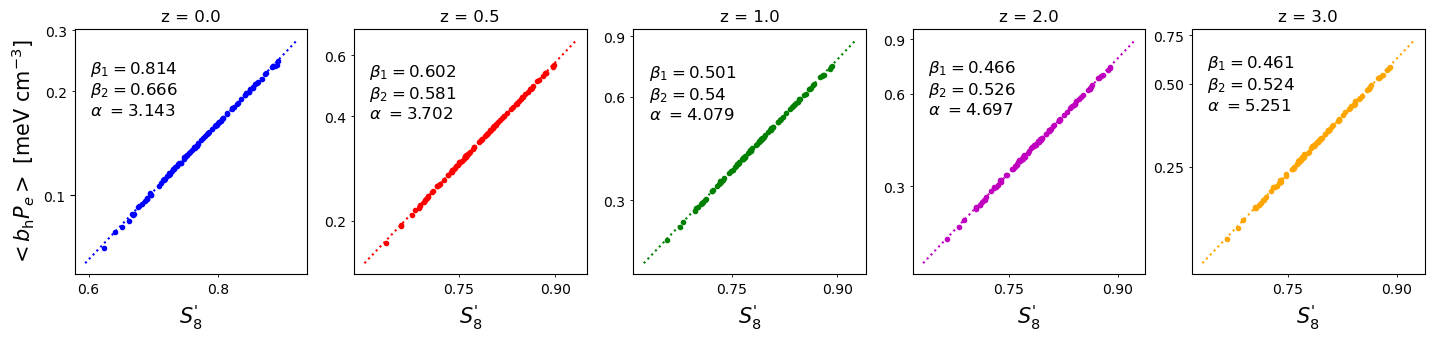

In [5]:
#version 1
beta1 = np.linspace(0.4, 0.9, 100)
beta2 = np.linspace(0.5, 0.7, 100)
c = ["b", "r", "g", "m", "orange"]
xmin=6
xmax=25
fig, ax = plt.subplots(1, 5, figsize = (5*3,3.5))
fig.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15)
for i in range(len(redshifts)):
    chi2 = np.zeros((len(beta1),len(beta2)))
    alpha = np.zeros((len(beta1),len(beta2)))
    A = np.zeros((len(beta1),len(beta2)))
    
    for jj in tqdm(range(len(beta1))):
        for kk in range(len(beta2)):
            # definition S'8
            S8 = sigma8*(Om0/0.3)**beta1[jj]*(h/0.7)**beta2[kk]
            #print(sigma8, (Om0/0.3)**beta1[jj],h, (h/0.7)**beta2[kk], S8)
            #raisr_error()
            p = np.polyfit(np.log10(S8), np.log10(bPe[:,i]), 1)
            alpha[jj, kk] = p[0]
            A[jj,kk] = 10**(p[1])
    
            chi2[jj, kk] = np.sum((A[jj,kk]*S8**alpha[jj, kk]-bPe[:,i])**2)
    ll = np.argmin(chi2)
    lj = ll//len(beta2)
    lk = ll%len(beta1)
    print(beta1[lj], beta2[lk])
        
    ax[i].plot(sigma8*(Om0/0.3)**beta1[lj]*(h/0.7)**beta2[lk], bPe[:,i], ".", c=c[i],
               label = "")
               
    xmin = np.min(sigma8*(Om0/0.3)**beta1[lj]*(h/0.7)**beta2[lk])*0.96
    xmax = np.max(sigma8*(Om0/0.3)**beta1[lj]*(h/0.7)**beta2[lk])/0.96
    ymax = np.max(bPe[:,i])
    ax[i].loglog(np.linspace(xmin, xmax, 100), A[lj, lk]*np.linspace(xmin, xmax, 100)**alpha[lj, lk], ":", c=c[i])
    #print()
    #ax[i].legend(bbox_to_anchor=(0., 1.02, 1, 1), loc='lower left',ncol=1, mode="expand", borderaxespad=0.,fontsize=14)   
    ax[i].set_xlabel(r"$S_8^'$", fontsize=15)
    ax[i].set_title("z = "+str(redshifts[i]))
    #ax[i].text(xmin*1, ymax*1.05, r"$S_8^' = (\sigma_8 (\frac{\Omega_m}{0.3})^{"+str(np.round(beta1[lj], 2))+r"}( \frac{h}{0.7})^{"+str(np.round(beta2[lk], 2))+"})^{"+str(np.round(alpha[lj, lk], 2))+"}$",
    #          fontsize=12)
    ax[i].text(xmin*1, ymax*0.7, "\n\n"+r" $\beta_1 = "+str(np.round(beta1[lj], 3))+"$ \n"+r" $\beta_2 = "+str(np.round(beta2[lj], 3))+ "$\n"+r" $\alpha\ = "+str(np.round(alpha[lj, lk], 3))+"$",
               fontsize=12, multialignment="left")
    #ax[i].set_xscale("log")
    #ax[i].set_yscale("log")
    from matplotlib.ticker import ScalarFormatter
    import matplotlib.ticker as ticker
    #ax[i].xaxis.set_major_formatter(ScalarFormatter())
    #ax[i].yaxis.set_major_formatter(ScalarFormatter())
    ax[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    
    ax[i].xaxis.set_minor_formatter(ScalarFormatter())
    ax[i].xaxis.set_minor_locator(ticker.MaxNLocator(2))
    
    ax[i].yaxis.set_minor_formatter(ScalarFormatter())
    ax[i].yaxis.set_minor_locator(ticker.MaxNLocator(3))
    #ax[i].minorticks_off()
    #break
ax[0].set_ylabel(r"$<b_{\rm h}P_e>\ \rm [meV\ cm^{-3}]$", fontsize=15) 
#plt.xlim(xmin, xmax)
%config InlineBackend.figure_format = 'svg'
plt.savefig("fig1.eps")
plt.savefig("fig1.png")
plt.savefig("fig1.pdf")
%config InlineBackend.figure_format = 'png'

# fig 2 main result

need data:
bPe_Pe_mean_mag.npz
bPe_Pe_mean_MTNG.npz

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


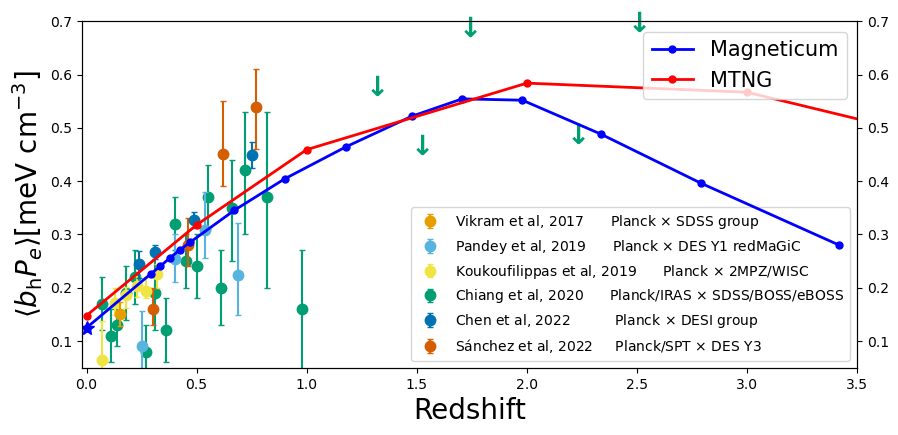

In [8]:
def plot_simu_bPe(ax, ifone = 1):
    #mag ['Box0', 'Box0_meshes', 'Box1a', 'Box2b']
    d = np.load("bPe_Pe_mean_mag.npz", allow_pickle=True)

    redshifts = np.hstack([ d["redshifts"][3],d["redshifts"][1][-1]])
    bPes = np.hstack([d["bPes"][3], d["bPes"][1][-1], ])
    if ifone:
        ax.plot(redshifts+1, bPes, '.-b', lw = 2,ms =10, label = "Magneticum")
    else:
        ax.plot(redshifts, bPes, '.-b', lw = 2,ms =10, label = "Magneticum")
        
        ax.plot(redshifts[-1], bPes[-1], '*b', lw = 2,ms =10)
        
    #MTNG
    d = np.load("bPe_Pe_mean_MTNG.npz")
    redshifts=d["redshifts"]
    Pe_means=d["Pe_means"]
    by=d["by"]
    
    if ifone:
        ax2.plot(redshifts+1, by*Pe_means, '-r',ms =10, lw = 2, label = "MTNG")
    else:
        ax2.plot(redshifts, by*Pe_means, '.-r',ms =10, lw = 2, label = "MTNG")
    ax2.legend()
def plot_papers_bPe(ax, ifone = 1):
    colors=["#E69F00","#56B4DF","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7"]


    #Vikram 2017
    z_V = 0.15
    bPe_V = 0.15
    bPe_err_V = 0.0226

    ax.errorbar(x= (ifone+z_V), y = bPe_V, yerr = bPe_err_V, color =colors[0], fmt=".", capsize=2, ms=15, label="Vikram et al, 2017 \t"+r"Planck $\times$ SDSS group", zorder = 10)

    # pandey 2019
    z_pan = np.array([0.25, 0.4, 0.54, 0.69])
    bPe_pan = np.array([0.9053, 2.547, 3.084, 2.242])/10
    bPe_errup_pan = np.array([1.589, 2.989, 3.611, 2.989])/10-bPe_pan
    bPe_errdown_pan = bPe_pan-np.array([0.2526, 2.087, 2.369, 1.274])/10
    ax.errorbar(x= (ifone+z_pan), y = bPe_pan, yerr = [bPe_errup_pan, bPe_errdown_pan], color =colors[1], fmt=".", capsize=2, ms=15, label="Pandey et al, 2019 \t"+r"Planck $\times$ DES Y1 redMaGiC")



    #koukou 2019
    z_kou = np.array([0.07, 0.13, 0.18, 0.23, 0.27, 0.32])
    bPe_kou = [0.064, 0.172, 0.187, 0.203, 0.194, 0.225]
    bPe_errup_kou = [0.022, 0.024, 0.025, 0.021, 0.014, 0.025]
    bPe_errdown_kou = [0.074, 0.028, 0.015, 0.019, 0.026, 0.019]
    ax.errorbar(x= (ifone+z_kou), y = bPe_kou, yerr = [bPe_errup_kou, bPe_errdown_kou], color =colors[3], fmt=".", capsize=2, ms=15, label="Koukoufilippas et al, 2019 \t"+r"Planck $\times$ 2MPZ/WISC")


    #chiang 2020
    z_chiang   = np.array([0.07, 0.11, 0.14, 0.18, 0.22, 0.27, 0.31, 0.36, 0.4,  0.45,  0.5, 0.55, 0.61, 0.66, 0.72, 0.82, 0.98])
    bPe_chiang = np.array([0.17, 0.11, 0.13, 0.19, 0.22, 0.08, 0.19, 0.12, 0.32, 0.25, 0.24, 0.37,  0.2, 0.35, 0.42, 0.37, 0.16])
    bPe_errup_chiang  = np.array([0.05, 0.05, 0.04, 0.05, 0.05, 0.06, 0.07, 0.06, 0.05, 0.05, 0.06, 0.06, 0.07,  0.1, 0.12, 0.17, 0.17])
    bPe_errdown_chiang= np.array([0.05, 0.05, 0.04, 0.05, 0.05, 0.05, 0.07, 0.06, 0.05, 0.05, 0.06, 0.06, 0.07, 0.09, 0.11, 0.16, 0.11])

    bPe_up = np.array([1.07, 0.56, 0.45, 0.67, 1.11, 0.47, 0.68, 1.34, 2.11])
    z_up   = np.array([1.15, 1.33, 1.53, 1.75, 1.98, 2.24, 2.52, 2.82, 3.15])

    ax.errorbar(x= (ifone+z_chiang), y = bPe_chiang, yerr = [bPe_errup_chiang, bPe_errdown_chiang], color =colors[2], fmt=".", capsize=2, ms=15, label="Chiang et al, 2020 \t" +r"Planck/IRAS $\times$ SDSS/BOSS/eBOSS", zorder = 1)
    for z, bPe in zip(z_up, bPe_up):
        if bPe > 0.8: continue
        #print(z, bPe)
        if ifone:
            ax.text(10**(np.log10(ifone+z)-0.007), bPe, u'\u2193', size=20,color=colors[2], fontweight='bold')  # 0.037: offset of arrow
        else:
            ax.text(z-0.06, bPe, u'\u2193', size=20,color=colors[2], fontweight='bold')  # 0.037: offset of arrow
            #ax.axvline(z)
    #chen 2022
    z_chen = np.array([0.24, 0.31, 0.49, 0.75])
    bPe_chen = [0.244, 0.267, 0.327, 0.449]
    bPe_err_chen = np.array([0.025, 0.013, 0.015, 0.024])

    ax.errorbar(x= (ifone+z_chen), y = bPe_chen, yerr = bPe_err_chen, color =colors[4], fmt=".", capsize=2, ms=15, label="Chen et al, 2022 \t"+r"  Planck $\times$ DESI group", zorder = 20)




    #DES  2022
    bPe =  np.array([0.16, 0.28, 0.45, 0.54])
    z = np.array([0.3, 0.46, 0.62, 0.77])
    bPe_errup =  np.array([0.03, 0.04, 0.06, 0.08])
    bPe_errdown =  np.array([0.04, 0.05, 0.10, 0.07])
    ax.errorbar(x= (ifone+z), y = bPe, yerr = [bPe_errup, bPe_errdown], color =colors[5], fmt=".", capsize=2,ms=15, label="Sánchez et al, 2022 \t" +r"Planck/SPT $\times$ DES Y3")

    ax.legend(loc = 4)
fig, ax = plt.subplots(figsize=(10, 4.5))
plot_papers_bPe(ax, 0)
ax2 = ax.twinx()
plot_simu_bPe(ax2, 0)
ax.set_xlim(-0.02, 3.5)
ax.set_ylim(0, 0.7)
ax2.set_ylim(0, 0.7)

ax2.legend(loc=1, fontsize = 15)
ax.set_ylim(0.05,0.7)
ax2.set_ylim(0.05,0.7)


ax.set_xlabel("Redshift", fontsize=20)
ax.set_ylabel(r"$\langle b_{\rm h}P_e \rangle [\rm meV\ cm^{-3}]$", fontsize=20)
%config InlineBackend.figure_format = 'svg'
fig.savefig("fig2.eps")
fig.savefig("fig2.png")
fig.savefig("fig2.pdf")
%config InlineBackend.figure_format = 'png'

# fig3  boxlen-mass resolution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


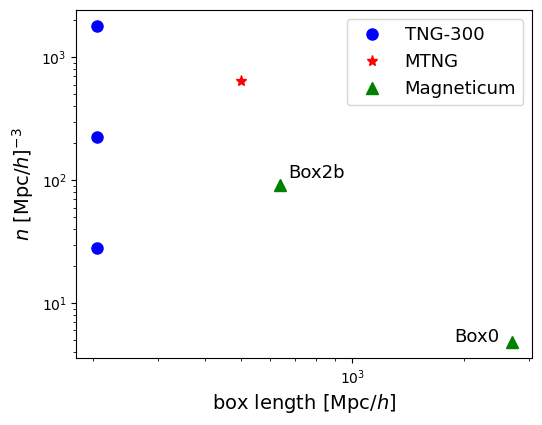

In [11]:
fig, ax = plt.subplots(figsize = (5.7, 4.3))
fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.14)
boxlen_ITNG = np.array([205, 205, 205])
N_ITNG = np.array([625, 1250, 2500])

boxlen_MTNG = np.array([500])
N_MTNG = np.array([4320])

boxlen_mag = np.array([2688, 640])
N_mag = np.array([4536, 2880])



ax.plot(boxlen_ITNG, (N_ITNG/boxlen_ITNG)**3, 'bo', ms = 8,label = "TNG-300")
ax.plot(boxlen_MTNG, (N_MTNG/boxlen_MTNG)**3, 'r*', ms = 8,label = "MTNG")
ax.plot(boxlen_mag,  (N_mag/boxlen_mag)**3,   'g^', ms = 8,label = "Magneticum")
ax.text(2688*0.7, (N_mag/boxlen_mag)[0]**3, "Box0", fontsize = 13)
ax.text(640*1.05, (N_mag/boxlen_mag)[1]**3*1.15, "Box2b", fontsize = 13)

ax.legend(fontsize = 13)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("box length [Mpc/$h$]", fontsize = 14)
ax.set_ylabel(r"$n\ [{\rm Mpc}/h]^{-3}$", fontsize = 14)
%config InlineBackend.figure_format = 'svg'
fig.savefig("fig3.eps")
fig.savefig("fig3.png")
fig.savefig("fig3.pdf")
%config InlineBackend.figure_format = 'png'

# fig 4 radio of P_pem / P_mm

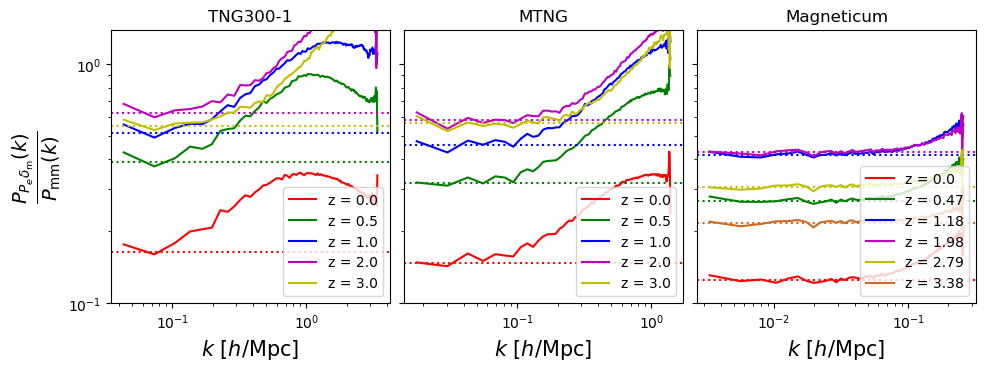

In [28]:
fig, ax =plt.subplots(1, 3, figsize=(10, 3.6), sharey=True, gridspec_kw={"wspace":0.05,})
fig.subplots_adjust(right=0.99, top = 0.91, bottom=0.15)
c = ["r", "g", "b", "m", "y", "chocolate"]
#ITNG
k_cut = 0.4
degree = 2
datadir = "/u/ziyang/data/TSZ_TNG/PK_deltape/"
simu_names = ["L205n1250TNG","L205n2500TNG","L205n625TNG","L35n1080TNG", "L35n2160TNG","L35n270TNG", "L35n540TNG", "L75n1820TNG", "L75n455TNG", "L75n910TNG"]

redshift2snapshot = {3:25, 2:33, 1:50, 0.5:67, 0:99}
redshifts = np.array([0, 0.5, 1, 2, 3])
MAS = "NGP"
grid=128
simu_name = simu_names[1]


for i in [0,1,2,3,4]:
    snap_no = redshift2snapshot[redshifts[i]]

    dataname = datadir+"PK_deltape_"+simu_name+"_"+str(snap_no)+"_"+MAS+"_"+str(grid)+".npz"
    d=np.load(dataname)
    k=d["k"]
    #Pe_simu[i] = d["Pe_mean"]
    ratio = d["Pe_mean"]*d["Pk_mPe"]/d["Pk_mm"]
    
    ax[0].plot(k, ratio, c=c[i], label = "z = "+str(redshifts[i]))
    
   
    model_poly = models.Polynomial1D(degree=degree)
    fitter_poly = fitting.LinearLSQFitter()
    label = np.where(k<k_cut)[0]
    best_fit_poly = fitter_poly(model_poly, k[label]**2, ratio[label])#, weights = (N_mode[label]))
    c0 = best_fit_poly.c0.value
    
    ax[0].axhline(c0, ls=":" , color=c[i])
    
    
#MTNG
k_cut = 0.18
degree = 2
datadir = "/u/ziyang/data/TSZ_MTNG/PK_deltape/"
simu_names = ["MTNG-L125-1080-A", "MTNG-L31.25-270-A", "MTNG-L500-4320-A", "MTNG-L62.5-540-A"]

redshift2snapshot = {3:94, 2:129, 1:179, 0.5:214, 0:264}
redshifts = np.array([0, 0.5, 1, 2, 3])
simu_name = simu_names[2]


for i in [0,1,2,3,4]:
    snap_no = redshift2snapshot[redshifts[i]]
    
    dataname = datadir+"PK_deltape_"+simu_name+"_"+str(snap_no)+"_"+MAS+"_"+str(grid)+".npz"
    d=np.load(dataname)
    k=d["k"]
    ratio = d["Pe_mean"]*d["Pk_mPe"]/d["Pk_mm"]
    
    ax[1].plot(k, ratio, c=c[i], label = "z = "+str(redshifts[i]))

    model_poly = models.Polynomial1D(degree=degree)
    fitter_poly = fitting.LinearLSQFitter()
    label = np.where(k<k_cut)[0]
    best_fit_poly = fitter_poly(model_poly, k[label]**2, ratio[label])#, weights = (N_mode[label]))
    c0 = best_fit_poly.c0.value
    ax[1].axhline(c0, ls=":" , color=c[i])
    
#magneticum
Mag_snap_no = [37,  25,  14,  10, 8,7]
print(1)
def mev_cm3_2_Pa():
    kg2ev_c2 = 1/(1.78*10**-36) #ev/c^2
    c_speed = 3*10**5
    h = 0.67
    return 10**29 *h**2/(kg2ev_c2/c_speed**2 * h**2 *10**3)# /10**17
def read_Pk_mag(no):
    
    file_name = "/u/ziyang/data/Magneticum/Box0_meshes/mag_pe_den_meshes_0"+str(no).zfill(2)+".hdf5"
    f = h5py.File(file_name)
    Boxsize = f["Header"].attrs["BoxSize"]
    Redshift = f["Header"].attrs["Redshift"]
    
    Pe = f["ElectronPressure"][:]
    M = f["MatterDensity"][:]
    Pe_mean = np.mean(Pe)
    Pe = Pe/np.mean(Pe)
    M = M/np.mean(M)
    blockPrint()
    Pk = PKL.XPk([M, Pe], Boxsize, axis=0, MAS=['CIC','CIC'], threads=1)
    enablePrint()
    k = Pk.k3D
    Pk_mm=Pk.Pk[:,0,0]
    Pk_PePe=Pk.Pk[:,0,1]
    Pk_mPe=Pk.XPk[:,0,0]
    return k, Pk_PePe, Pk_mPe, Pk_mm, Redshift, Pe_mean*10**17
for i in range(len(Mag_snap_no)):
    no = Mag_snap_no[i]
    k, Pk_pepe, Pk_mpe, Pk_mm, Redshift, Pe_mean = read_Pk_mag(no)
    ax[2].plot(k, Pe_mean*Pk_mpe/Pk_mm/mev_cm3_2_Pa(), c=c[i], label="z = "+str(np.round(Redshift, 2)))
    
    label = np.where(k<0.03)
    ax[2].axhline(np.mean((Pe_mean*Pk_mpe/Pk_mm/mev_cm3_2_Pa())[label]), ls=":" , color=c[i])
    
    
    ax[2].set_title("Magneticum")
    
    
    
ax[0].set_title("TNG300-1")   
ax[1].set_title("MTNG")   
ax[2].set_title("Magneticum")   
for i in range(3):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_ylim(0.1,0.7*2)
    ax[i].legend(loc=4)
    ax[i].set_xlabel(r"$k\ [h/\rm Mpc]$", fontsize=15)
    ax[0].set_ylabel(r"$\frac{P_{P_e \delta_{\rm m}}(k)}{P_{\rm mm}(k)}$", fontsize=20)
    
%config InlineBackend.figure_format = 'svg'
fig.savefig("fig4.eps")
fig.savefig("fig4.pdf")
fig.savefig("fig4.png")
%config InlineBackend.figure_format = 'png'

# fig 5 compare different cosmology

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


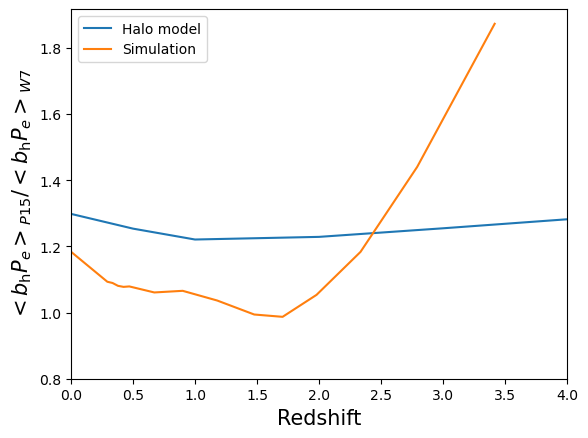

In [31]:
Mpc2cm = 3.08*10**24


boxlen_mtng = 500 #cMpc/h

#bPe measurements from simulations
d = np.load("bPe_Pe_mean_mag.npz", allow_pickle=True)
redshifts_mag = np.hstack([ d["redshifts"][3],0])
bPes_Mag = np.hstack([d["bPes"][3], d["bPes"][1][-1], ])

d = np.load("bPe_Pe_mean_MTNG.npz")
redshifts_tng=d["redshifts"]
Pe_means=d["Pe_means"]
by=d["by"]
bPe_MTNG = Pe_means*by

#redshifts_tng = np.array([0, 0.5, 1, 2, 3])
bPe_ITNG = [0.16405683, 0.38932994, 0.51581449, 0.62728464, 0.54969911]


redshifts=[0,0.5, 1,2,3, 4]

lgM_edges=np.linspace(12, 15, 101)
lgM_bin= (lgM_edges[1:]+lgM_edges[:-1])/2

#Pe_sum = np.zeros((len(lgM_bin), 5))
#N = np.zeros((len(lgM_bin), 5))
#for i in tqdm(range(5)):
#    N[:,i], Pe_sum[:,i] = get_pe_profile_simu(lgM_edges=lgM_edges, redshift=redshifts[i], x_max_cut = 6)
#bPe_mtng =  bPe_calculate(redshifts=redshifts, cosmo_model = "P13",lgM_bin = lgM_bin, 
#                          Pe_model = "simu", Pe_simu=Pe_sum, #Pe_simu.shape =  len(M) meV
#                         hmf_model = "simu", hmf_simu = N/boxlen_mtng**3)

P13_params = {'flat': True, 'H0': 67.74, 'Om0': 0.3089, 'Ob0': 0.0486, 'sigma8': 0.8159, 'ns': 0.9667}  #Planck13, TNG
#P13_params_ = {'flat': True, 'H0': 67.74, 'Om0': 0.272, 'Ob0': 0.0486, 'sigma8': 0.8159, 'ns': 0.9667}  #Planck13, TNG


W7_params  = {'flat': True, 'H0': 70.4,  'Om0': 0.272,  'Ob0': 0.0456, 'sigma8': 0.809,  'ns': 0.963}   #WMAP 7, Mag
#W7_params_  = {'flat': True, 'H0': 67.74,  'Om0': 0.3089,  'Ob0': 0.0486, 'sigma8': 0.816,  'ns': 0.9667}   #WMAP 7, Mag

#cosmology.addCosmology('W7_2', **W7_params_)
cosmology.addCosmology('W7', **W7_params)
cosmology.addCosmology('P13', **P13_params)

bPe_P13 = bPe_calculate(redshifts=redshifts, cosmo_model = "P13")
bPe_W7  = bPe_calculate(redshifts=redshifts, cosmo_model = "W7")
#plt.plot(redshifts, bPe_fid.bPe, )
plt.plot(redshifts, bPe_P13.bPe/bPe_W7.bPe, label = "Halo model")
#f = interpolate.interp1d(redshifts_mag, bPes_Mag)

f = interpolate.interp1d(redshifts_tng, bPe_MTNG)
plt.plot(redshifts_mag, f(redshifts_mag)/bPes_Mag, label = "Simulation")

f = interpolate.interp1d(redshifts_mag, bPes_Mag)
#plt.plot(redshifts_tng[:-1], bPe_MTNG[:-1]/f(redshifts_tng[:-1]), label = "Simulation")

#plt.plot(redshifts_mag, bPe_Mag, ":", label = "Mag")
plt.legend()
plt.ylim(0.8, )
plt.xlim(0,4)
#plt.title("Medf = 500c")
plt.ylabel(r"$<b_{\rm h}P_e>_{P15}/<b_{\rm h}P_e>_{W7}$", fontsize = 15)
plt.xlabel("Redshift", fontsize = 15)
%config InlineBackend.figure_format = 'svg'
plt.savefig("fig5.eps")
plt.savefig("fig5.pdf")
plt.savefig("fig5.png")
%config InlineBackend.figure_format = 'png'

# fig 6: contribution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


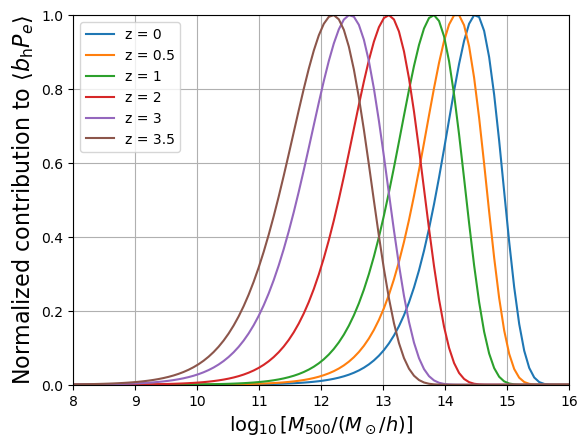

In [33]:
cosmology.setCosmology("planck15")
fig, ax = plt.subplots()

redshifts  = [0,0.5,1, 2, 3,3.5]
bias_model = 'tinker10';hmf_model = 'tinker08';mdef = "500c"
lgM_min = 8; lgM_max = 16; lgM_nbin = 100
lgM_bins = np.linspace(lgM_min, lgM_max, lgM_nbin)
dlgM = lgM_bins[1]-lgM_bins[0]
alpha_p=0.12
for i in range(len(redshifts)):
    bh = bias.haloBias(10**lgM_bins, model = bias_model, z = redshifts[i], mdef = mdef)
    dndlgM=mass_function.massFunction(10**lgM_bins, z = redshifts[i], mdef = mdef,
                                              model = hmf_model, q_out = 'dndlnM')*np.log(10) #len(M)
    A = bh*dndlgM*10**(lgM_bins*(5/3+alpha_p))
    label = np.where(lgM_bins<12)[0]
    print(np.sum(A[label])/np.sum(A))
    plt.plot(lgM_bins, A/np.max(A), label = "z = "+str(redshifts[i]))
    
plt.legend()
plt.xlabel("$\log_{10}[M_{500}/(M_\odot/h)]$", font={"size":14})
plt.ylabel(r"Normalized contribution to $\langle b_{\rm h}P_e \rangle$", font={"size":16})
plt.title("")

plt.xlim(8, 16)
plt.ylim(0,1)

%config InlineBackend.figure_format = 'svg'
fig.savefig("fig6.eps")
fig.savefig("fig6.pdf")
fig.savefig("fig6.png")
%config InlineBackend.figure_format = 'png'

plt.grid()

# fig7 resolution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


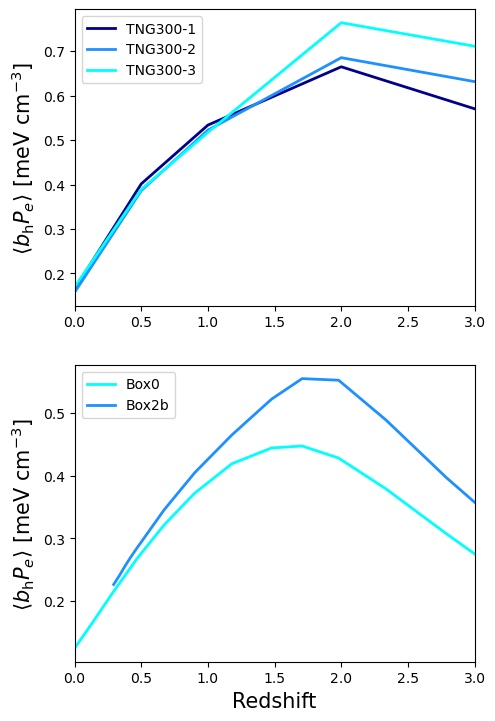

In [3]:
fig, axs = plt.subplots(2, 1, figsize = (5, 7.5))
fig.subplots_adjust(left=0.15, right=0.95, top=0.97, bottom=0.1)
#mag ['Box0', 'Box0_meshes', 'Box1a', 'Box2b']
["darkblue","blue", "dodgerblue", "cyan", "paleturquoise"]
d = np.load("bPe_Pe_mean_mag.npz", allow_pickle=True)
c = ["b", "cyan", "a", "dodgerblue"]
label = ["b", "Box0", "a", "Box2b"]
for i in [1,3]:
    redshifts = d["redshifts"][i]
    bPes = d["bPes"][i]
    Pe_means=d["Pe_means"][i]
    bPes=d["bPes"][i]

    axs[1].plot(redshifts, bPes, c=c[i], lw=2, label = label[i])

#ITNG
d = np.load("bPe_Pe_mean_ITNG.npz")
c= [ "dodgerblue", "darkblue", "cyan",]
TNG_names = ["TNG300-2", "TNG300-1", "TNG300-3"]
for i in [1,0,2]:
    redshifts = d["redshifts"]
    Pe_means = d["Pe_means"][i,:]
    by=d["by"][i,:]
    bPes=Pe_means*by

    axs[0].plot(redshifts, bPes, c=c[i],lw=2,label = TNG_names[i])


for ax in axs:
    ax.legend()
    ax.set_xlim(0,3)
    ax.set_ylabel(r"$\langle b_{\rm h}P_e \rangle \ \rm [meV\ cm^{-3}]$", fontsize=15)
axs[1].set_xlabel("Redshift", fontsize=15)
%config InlineBackend.figure_format = 'svg'
fig.savefig("fig7.eps")
fig.savefig("fig7.pdf")
fig.savefig("fig7.png")
%config InlineBackend.figure_format = 'png'

# fig 9 : one-halo term radio

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


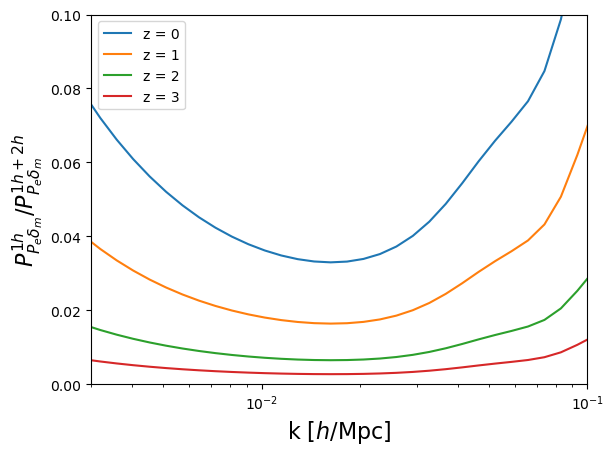

In [4]:
fig, ax = plt.subplots()
redshifts = [0, 1, 2, 3, ]
for i in range(len(redshifts)):
    HM = halo_model(redshift = redshifts[i])
    ax.plot(HM.k, HM.Pk_mpe_1h/(HM.Pk_mpe_1h+HM.Pk_mpe_2h),  label = r"z = "+str(redshifts[i]))
    #ax.plot(HM.k, HM.Pk_pepe_2h,  label = r"z = "+str(redshifts[i]))
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend()
ax.set_ylim(0, 0.1)
ax.set_xlim(0.003, 0.1)
ax.set_xlabel("k [$h$/Mpc]", fontsize = 16)
ax.set_ylabel("$P_{P_e\delta_m}^{1h} / P_{P_e\delta_m}^{1h+2h}$", fontsize = 16)
%config InlineBackend.figure_format = 'svg'
fig.savefig("fig9.eps")
fig.savefig("fig9.pdf")
fig.savefig("fig9.png")
%config InlineBackend.figure_format = 'png'

# fig 10: correlation r

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


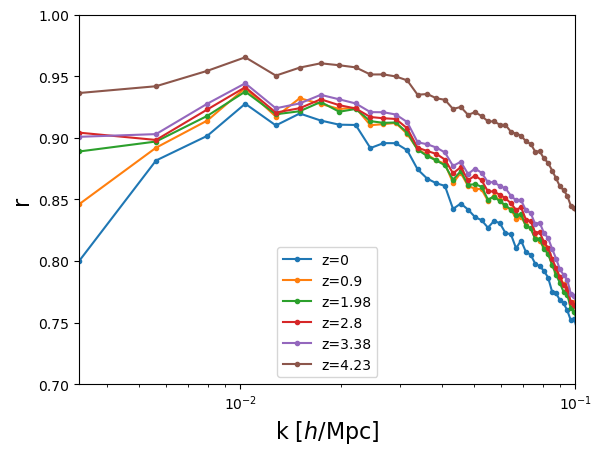

In [46]:
# cosmo_model
params = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
W7_params  = {'flat': True, 'H0': 70.4,  'Om0': 0.272,  'Ob0': 0.0456, 'sigma8': 0.809,  'ns': 0.963}   #WMAP 7, Mag
cosmology.addCosmology('W7' , **W7_params)

#fig, axs = plt.subplots(6, 2, figsize = (7, 2*6), sharex=True, gridspec_kw={"hspace":0.1,"wspace":0,})
fig, ax = plt.subplots()
redshifts = [0, 0.9, 1.98, 2.8, 3.38, 4.23]
snap_no = [37, 17, 10, 8, 7, 6]
for i in range(len(redshifts)):
    #ax=axs[i, 0]
    
    file_name = "/u/ziyang/data/Box0/mag_pe_den_meshes_0"+str(snap_no[i]).zfill(2)+".hdf5"
    f = h5py.File(file_name)

    Boxsize = f["Header"].attrs["BoxSize"]
    Redshift = f["Header"].attrs["Redshift"]
    Pe = f["ElectronPressure"][:]
    M = f["MatterDensity"][:]
    Pe = Pe/np.mean(Pe)
    M = M/np.mean(M)
    Pk = PKL.XPk([M, Pe], Boxsize, axis=0, MAS=['CIC','CIC'], threads=1)
    k_mag = Pk.k3D
    pk_mm_mag=Pk.Pk[:,0,0]
    pk_pepe_mag=Pk.Pk[:,0,1]
    pk_pem_mag=Pk.XPk[:,0,0]
    ax.plot(k_mag, pk_pem_mag/np.sqrt(pk_pepe_mag*pk_mm_mag), '.-', label = "z="+str(redshifts[i]))
    
   
   
    #break
ax.set_xscale("log")
ax.legend()
ax.set_xlim(k_mag[0], 0.1)
ax.set_ylim(0.7, 1)
ax.set_xlabel("k [$h$/Mpc]", fontsize = 16)
ax.set_ylabel("r", fontsize = 16)
%config InlineBackend.figure_format = 'svg'
fig.savefig("fig10.eps")
fig.savefig("fig10.png")
fig.savefig("fig10.pdf")
%config InlineBackend.figure_format = 'png'

# fig 11: remove halos in ITNG

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


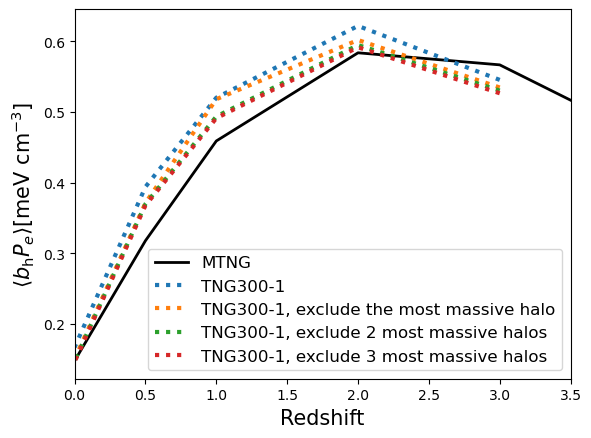

In [52]:
def plot_simu_bPe_app(ax, ifone = 0):    
    #MTNG
    d = np.load("bPe_Pe_mean_MTNG.npz")
    redshifts=d["redshifts"]
    Pe_means=d["Pe_means"]
    by=d["by"]
    
    if ifone:
        ax.plot(redshifts+1, by*Pe_means, '-r',ms =10, lw = 2, label = "MTNG")
    else:
        ax.plot(redshifts, by*Pe_means, 'k',ms =10, lw = 2, label = "MTNG")
    
def plot_itng_masked(ax):
    f = h5py.File("itng_mask_massive_halos.hdf5")
    f.keys()
    redshift = f["Redshift"][:]
    bPe_all  = f["bPe_AllHalos"][:]
    bPe_mask1 = f["bPe_Mask1"][:]
    bPe_mask2 = f["bPe_Mask2"][:]
    bPe_mask3 = f["bPe_Mask3"][:]
    print(bPe_all)
    ax.plot(redshift, bPe_all, ':',lw=3,label = "TNG300-1")
    ax.plot(redshift, bPe_mask1, ':',lw=3, label = "TNG300-1, exclude the most massive halo")
    ax.plot(redshift, bPe_mask2, ':',lw=3, label = "TNG300-1, exclude 2 most massive halos")
    ax.plot(redshift, bPe_mask3, ':',lw=3, label = "TNG300-1, exclude 3 most massive halos")
    
fig, ax = plt.subplots()
plot_simu_bPe_app(ax)
plot_itng_masked(ax)
ax.legend(fontsize =12)
ax.set_xlabel("Redshift", fontsize =15)
ax.set_ylabel(r"$\langle b_{\rm h}P_e \rangle [\rm meV\ cm^{-3}]$", fontsize =15)
ax.set_xlim(0, 3.5)

%config InlineBackend.figure_format = 'svg'
fig.savefig("fig11.eps")
fig.savefig("fig11.png")
fig.savefig("fig11.pdf")

%config InlineBackend.figure_format = 'png'



# fit A

0.5037974683544304 1.0484848484848486 0.024107936408306236


Text(0.4, 1.115, 'when $z<z_{max}$.')

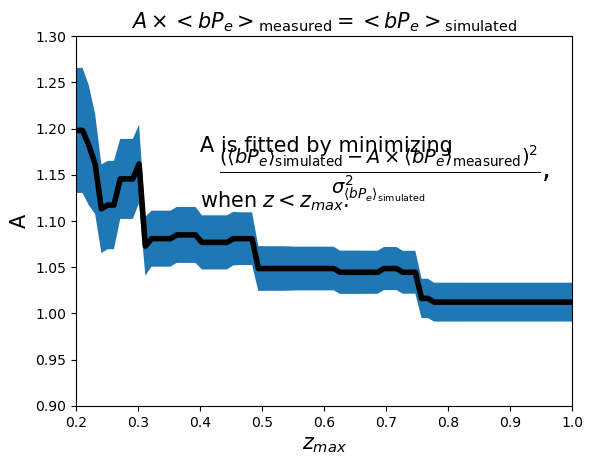

In [2]:
def fit_A_measurements_data():
    
    redshifts = []
    bPes = []
    bPes_error = []
    
    #Vikram 2017
    z_V = 0.15
    bPe_V = 0.15
    bPe_err_V = 0.0226
    
    redshifts.append(z_V)
    bPes.append(bPe_V)
    bPes_error.append(bPe_err_V)

    

    # pandey 2019
    z_pan = np.array([0.25, 0.4, 0.54, 0.69])
    bPe_pan = np.array([0.9053, 2.547, 3.084, 2.242])/10
    bPe_errup_pan = np.array([1.589, 2.989, 3.611, 2.989])/10-bPe_pan
    bPe_errdown_pan = bPe_pan-np.array([0.2526, 2.087, 2.369, 1.274])/10
   
    redshifts.append(z_pan)
    bPes.append(bPe_pan)
    bPes_error.append((bPe_errup_pan+bPe_errdown_pan)/2)
    


    #koukou 2019
    z_kou = np.array([0.07, 0.13, 0.18, 0.23, 0.27, 0.32])
    bPe_kou = np.array([0.064, 0.172, 0.187, 0.203, 0.194, 0.225])
    bPe_errup_kou = np.array([0.022, 0.024, 0.025, 0.021, 0.014, 0.025])
    bPe_errdown_kou = np.array([0.074, 0.028, 0.015, 0.019, 0.026, 0.019])
    
    redshifts.append(z_kou)
    bPes.append(bPe_kou)
    bPes_error.append(np.array(bPe_errup_kou+bPe_errdown_kou)/2)
    

    #chiang 2020
    z_chiang   = np.array([0.07, 0.11, 0.14, 0.18, 0.22, 0.27, 0.31, 0.36, 0.4,  0.45,  0.5, 0.55, 0.61, 0.66, 0.72, 0.82, 0.98])
    bPe_chiang = np.array([0.17, 0.11, 0.13, 0.19, 0.22, 0.08, 0.19, 0.12, 0.32, 0.25, 0.24, 0.37,  0.2, 0.35, 0.42, 0.37, 0.16])
    bPe_errup_chiang  = np.array([0.05, 0.05, 0.04, 0.05, 0.05, 0.06, 0.07, 0.06, 0.05, 0.05, 0.06, 0.06, 0.07,  0.1, 0.12, 0.17, 0.17])
    bPe_errdown_chiang= np.array([0.05, 0.05, 0.04, 0.05, 0.05, 0.05, 0.07, 0.06, 0.05, 0.05, 0.06, 0.06, 0.07, 0.09, 0.11, 0.16, 0.11])

    redshifts.append(z_chiang)
    bPes.append(bPe_chiang)
    bPes_error.append((bPe_errup_chiang+bPe_errdown_chiang)/2)

    #chen 2022
    z_chen = np.array([0.24, 0.31, 0.49, 0.75])
    bPe_chen = [0.244, 0.267, 0.327, 0.449]
    bPe_err_chen = np.array([0.025, 0.013, 0.015, 0.024])

    redshifts.append(z_chen)
    bPes.append(bPe_chen)
    bPes_error.append(bPe_err_chen)
    
    #DES  2022
    bPe =  np.array([0.16, 0.28, 0.45, 0.54])
    z = np.array([0.3, 0.46, 0.62, 0.77])
    bPe_errup =  np.array([0.03, 0.04, 0.06, 0.08])
    bPe_errdown =  np.array([0.04, 0.05, 0.10, 0.07])
    
    redshifts.append(z)
    bPes.append(bPe)
    bPes_error.append((bPe_errup+bPe_errdown)/2)


    
    return np.hstack(redshifts), np.hstack(bPes), np.hstack(bPes_error)

def fit_A_simulation_data():
    from scipy import interpolate
    #MTNG
    d = np.load("bPe_Pe_mean_MTNG.npz")
    redshifts=d["redshifts"]
    Pe_means=d["Pe_means"]
    by=d["by"]
    
    f = interpolate.interp1d(redshifts, by*Pe_means)
    return f


z_mea, bPe_mea, bpe_err_mea = fit_A_measurements_data()
f_simu = fit_A_simulation_data()

z_up_cut = np.linspace(0.2, 1, 80)
A_fit = np.zeros(len(z_up_cut))
sigma = np.zeros(len(z_up_cut))
for j in range(len(z_up_cut)):
    A = np.linspace(1, 1.4, 100)
    chi2 = np.zeros(len(A))
    for i in range(len(A)):
        label = np.where(z_mea<z_up_cut[j])
        chi2[i] = np.sum((A[i]*bPe_mea[label]-f_simu(z_mea[label]))**2/bpe_err_mea[label]**2)
    A_fit[j] = A[np.argmin(chi2)]
    sigma[j] = np.sqrt(1/np.sum((bPe_mea[label]/bpe_err_mea[label])**2))
print(z_up_cut[30], A_fit[30],sigma[30])
plt.plot(z_up_cut, A_fit, "k", lw=4)
plt.fill_between(z_up_cut, A_fit-sigma, A_fit+sigma)
plt.plot(z_up_cut, sigma, "k", lw=1)
plt.xlim(0.2, 1)
plt.ylim(0.9, 1.3)
plt.xlabel("$z_{max}$", fontsize=15)
plt.ylabel("A", fontsize=15)
plt.title(r"$A\times <bP_e>_{\rm measured} = <bP_e>_{\rm simulated}$", fontsize=15)
plt.text(0.4, 1.175, "A is fitted by minimizing", fontsize=15)
plt.text(0.43, 1.145, r"$\frac{(\langle bP_e \rangle_{\rm simulated}-A \times \langle bP_e \rangle_{\rm  measured})^2}{\sigma^2_{\langle bP_e \rangle_{\rm simulated}}}, $", fontsize=20)
plt.text(0.4, 1.115, "when $z<z_{max}$.", fontsize=15)

In [6]:
print(1)